# Tutorial for _Mixture Density Network Estimation of Continuous Variable Maximum Likelihood Using Discrete Training Samples_
**ArXiv:** https://arxiv.org/abs/2103.13416

**Abstract**:
Mixture Density Networks (MDNs) can be used to generate posterior density functions of model parameters $\theta$ given a set of observables $x$. In some applications, training data are available only for discrete values of a continuous parameter $\theta$. In such situations, a number of performance-limiting issues arise which can result in biased estimates. We demonstrate the usage of MDNs for parameter estimation, discuss the origins of the biases, and propose a corrective method for each issue.

## Introduction
We demonstrate the use of Mixture Density Networks (MDNs) to estimate an underlying physical parameter which is not directly observable in the data, but rather inferred from other event information. Specifically, we will consider the case in which the training data is limited to discrete values of the desired parameter.

As a concrete example, suppose one sought to measure the mass of the top quark. This will be the parameter of interest, $\theta$. While we do not experimentally observe the top quark directly, and thus cannot measure $\theta$ directly, we can instead calculate some event observable $x$, the distribution of which is dependent on the value of $\theta$. For this example, $x$ could be the invariant mass of a sum of some of the top decay products in the event. In statistical terms, this means that there is some statistical model $p(x|\theta)$ which relates the value of the unknown parameter $\theta$ to the distribution of $x$ values.

Unfortunately, it is often difficult to create an analytic model which completely represents a complicated function like $p(x|\theta)$: detector effects, correlations, and multiple observables $\mathbf{x}$. Instead, we seek to solve the inverse problem, we us a neural network to estimate a likelihood function $\mathcal{L}(\theta|x)$. This function answers the question, "given some event with a measured observable $x$, what is the likelihood that that event is consistent with a parameter value of $\theta$?"

To do this, we will train an MDN to learn a posterior density $p(\theta|x)$. With Bayes' Theorem, we can convert this posterior density into a likelihood,
$$\mathcal{L}(\theta|x) = p(x|\theta) = \frac{p(\theta|x) p(x)}{p(\theta)}.$$
(See the paper for full details.) By teaching the MDN to model the posterior, we can create a maximum likelihood estimator of $\theta$ for a given dataset $\left\{ x_i \right\}$. Specifically, if $p(\theta)$ is a constant function, maximizing the product
$$\mathcal{C}' = \prod_i p \left( \theta | x_i \right)$$
with respect to $\theta$ also maximizes the likelihood.

Finally, we note that this paper/method deals with discrete training samples. In many applications, one may not have the ability to generate training data along a continuous spectrum of $\theta$ values. For the aforementioned top mass analysis, the Monte Carlo event generators do not support the generation of events along a continuum of top mass values. Instead, the physicist will generate discrete samples (a.k.a. "templates") at a number of possible values of $\theta$ on a grid.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import torch

In [2]:
_GPU = torch.cuda.is_available()

## 1) Training Data
Suppose we have an underlying parameter $\theta \in [0, 1]$ and an observable $x \in \mathbb{R}$ which are related a statistical model $p(x|\theta)$. (The usefulness of this technique over other methods is greatest when the statistical model is complicated and/or multidimensional, but we'll stick to very simple cases in this notebook for didactic reasons, in hopes that they can be built upon by the reader.) We'll plot this model for two possible values of $\theta$, $0.25$ and $0.75$.

In [3]:
# The three model parameters
_MU_M = 1 # slope
_MU_B = 0 # intercept
_SIGMA = 1 # width

In [4]:
x_samples = np.linspace(0, 1, 100)
model_0 = stats.norm(loc=_MU_M * 0.25 + _MU_B, scale=_SIGMA)
model_1 = stats.norm(loc=_MU_M * 0.75 + _MU_B, scale=_SIGMA)
model_0_samples = model_0.pdf(x_samples) / (model_0.cdf(1) - model_0.cdf(0) + 1e-9)
model_1_samples = model_1.pdf(x_samples) / (model_1.cdf(1) - model_1.cdf(0) + 1e-9)

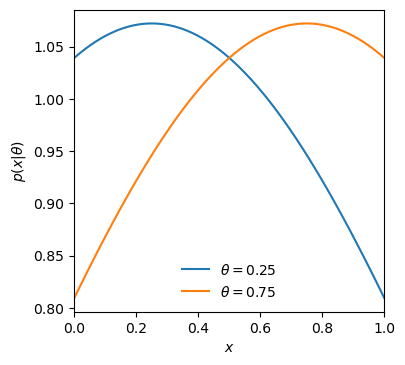

In [5]:
plt.figure(figsize=(4, 4), dpi=100)
plt.plot(x_samples, model_0_samples, label=r'$\theta={0.25}$')
plt.plot(x_samples, model_1_samples, label=r'$\theta={0.75}$')
plt.xlabel(r'$x$')
plt.ylabel(r'$p(x|\theta)$')
plt.xlim(0, 1)
plt.legend(frameon=False)
plt.show()

### 1a) Continuous Training Data
In an ideal situation, we would generate training data along a continuum of possible $\theta$ values.

In [6]:
n_training = 1_000_000
t_training = np.random.uniform(size=n_training)
x_training = np.random.normal(loc=t_training, scale=_SIGMA)

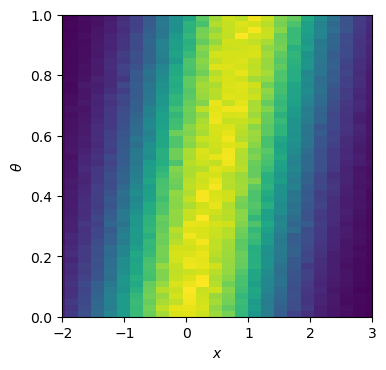

In [7]:
plt.figure(figsize=(4, 4), dpi=100)
plt.hist2d(x_training, t_training, bins=50)
plt.xlabel(r'$x$')
plt.ylabel(r'$\theta$')
plt.xlim(-2, 3)
plt.ylim(0, 1)
plt.show()

This dataset has the nice effect of enforcing a flat $p(\theta)$. This would produce no bias.

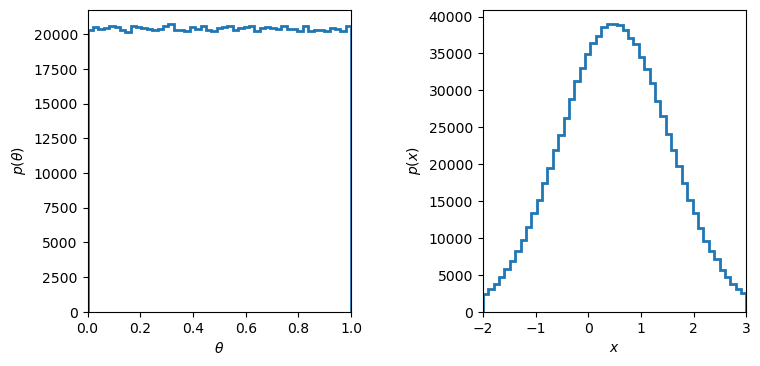

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(8.5, 4), dpi=100)
fig.subplots_adjust(wspace=0.5)
axs[0].hist(t_training, np.linspace(0, 1, 50), histtype='step', linewidth=2)
axs[0].set_xlabel(r'$\theta$')
axs[0].set_ylabel(r'$p(\theta)$')
axs[0].set_xlim(0, 1)
axs[1].hist(x_training, np.linspace(-2, 3, 50), histtype='step', linewidth=2)
axs[1].set_xlabel(r'$x$')
axs[1].set_ylabel(r'$p(x)$')
axs[1].set_xlim(-2, 3)
plt.show()

### 1b) Discrete Training Data (Naive)
Instead, let's consider the case of interest where we can only generate events at discrete values of $\theta$. A naive approach may be to choose 10 points equally distributed across the range.

In [9]:
thetas = np.linspace(0, 1, 10)[1:-1]
print(thetas)

n_training = 100_000 # number of points for each template
x_training = np.random.normal(loc=_MU_M * thetas + _MU_B, scale=_SIGMA, size=(n_training, len(thetas))).T
t_training = np.repeat(thetas, n_training).reshape(x_training.shape)

[0.11111111 0.22222222 0.33333333 0.44444444 0.55555556 0.66666667
 0.77777778 0.88888889]


Here is the _true_ $p(x|\theta)$ for this dataset.

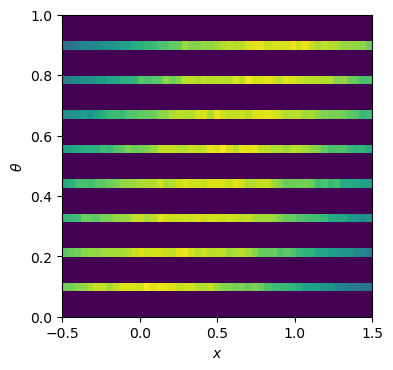

In [10]:
plt.figure(figsize=(4, 4), dpi=100)
plt.hist2d(x_training.ravel(), t_training.ravel(), bins=[np.linspace(-0.5, 1.5, 50), np.linspace(0, 1, 36)])
plt.xlabel(r'$x$')
plt.ylabel(r'$\theta$')
plt.show()

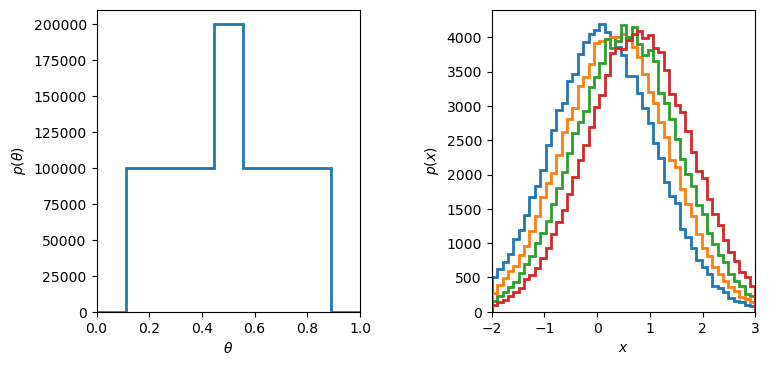

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(8.5, 4), dpi=100)
fig.subplots_adjust(wspace=0.5)
axs[0].hist(t_training.ravel(), np.linspace(-0.001, 1.001, 10), histtype='step', linewidth=2)
axs[0].set_xlabel(r'$\theta$')
axs[0].set_ylabel(r'$p(\theta)$')
axs[0].set_xlim(0, 1)
for x in x_training[::2]:
    axs[1].hist(x, np.linspace(-2, 3, 50), histtype='step', linewidth=2)
axs[1].set_xlabel(r'$x$')
axs[1].set_ylabel(r'$p(x)$')
axs[1].set_xlim(-2, 3)
plt.show()

Notice that $p(\theta)$ is no longer constant. Instead, the density of training points is lower near the edges. We discovered that this produces a biased result, as the network is reluctant to predict $\theta$ values where there is little training data.

### 1c) Discrete Training Data (Properly)
Instead, will use templates at values of $\theta \in \left[ 0, 1 \right]$ which ensure a flat distribution of training data.

In [12]:
thetas = np.array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95])

In [13]:
n_training = 100_000 # number of points for each template
x_training = np.random.normal(loc=_MU_M * thetas + _MU_B, scale=_SIGMA, size=(n_training, len(thetas))).T
t_training = np.repeat(thetas, n_training).reshape(x_training.shape)

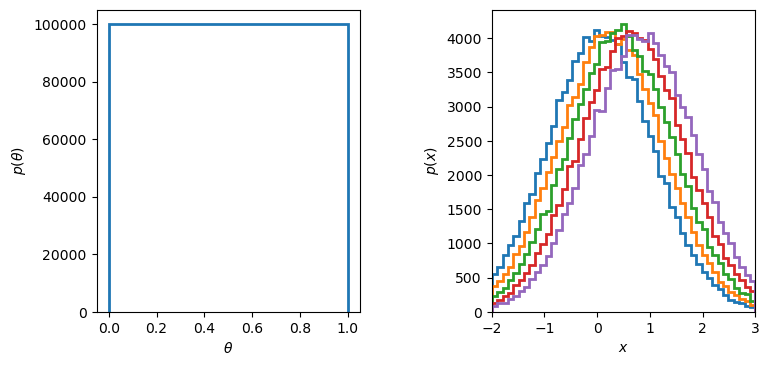

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(8.5, 4), dpi=100)
fig.subplots_adjust(wspace=0.5)
axs[0].hist(t_training.ravel(), np.linspace(-0.001, 1.001, 11), histtype='step', linewidth=2)
axs[0].set_xlabel(r'$\theta$')
axs[0].set_ylabel(r'$p(\theta)$')
for x in x_training[::2]:
    axs[1].hist(x, np.linspace(-2, 3, 50), histtype='step', linewidth=2)
axs[1].set_xlabel(r'$x$')
axs[1].set_ylabel(r'$p(x)$')
axs[1].set_xlim(-2, 3)
plt.show()

In preparation for inputing these into the neural network, we need shuffled PyTorch tensors (which are appropriately shaped).

In [15]:
training = list(zip(t_training.ravel(), x_training.ravel()))
np.random.shuffle(training)
t_training, x_training = zip(*training)
t_training = torch.tensor(t_training, dtype=torch.float).unsqueeze(1)
x_training = torch.tensor(x_training, dtype=torch.float).unsqueeze(1)
if _GPU:
    t_training = t_training.cuda()
    x_training = x_training.cuda()

## 2) Mixture Density Networks
First, some helper functions for the GaussianMDN class.

In [16]:
def hermitePolynomial(t, device='cpu', integral=False):
    '''A helper function for creating a spline.
    
    Manually implemented since it is not included in PyTorch, and numpy functions
    are not able to handle backpropogation.'''
    nt = t.nelement()
    hermite = torch.empty(4, nt, device=device)

    if integral:
        hermite[0] = t
        for i in range(1, 4):
            hermite[i] = hermite[i - 1] * t * i / (i + 1)
    else:
        hermite[0] = 1
        for i in range(1, 4):
            hermite[i] = hermite[i - 1] * t

    A = torch.tensor([
        [1, 0, -3, 2],
        [0, 1, -2, 1],
        [0, 0, 3, -2],
        [0, 0, -1, 1]
    ], dtype=torch.float32, device=device)

    return A.matmul(hermite)

def spline(x, y, samples, device='cpu'):
    '''Creates a spline of a set of points which is then evaluated at samples.'''
    ydiff = y[1:] - y[:-1]
    xdiff = x[1:] - x[:-1]
    slope = ydiff / xdiff
    slopeavg = torch.cat([slope[[0]], 0.5 * (slope[1:] + slope[:-1]), slope[[-1]]])

    # find the location of the nearest known x location for each sample
    indices = torch.searchsorted(x[1:], samples)
    # the interval between the two nearest known x locations
    dx = x[indices + 1] - x[indices]

    # normalize the x range to the interval [0, 1]
    unit_samples = (samples - x[indices]) / dx
    hermite = hermitePolynomial(unit_samples, device)

    c0 = hermite[0] * y[indices] + hermite[2] * y[indices + 1]
    c1 = dx * (hermite[1] * slopeavg[indices] + hermite[3] * slopeavg[indices + 1])
    return c0 + c1

In [17]:
class GaussianMDN(torch.nn.Module):
    '''Network that outputs coefficients of a mixture of gaussians likelihood function

    Arguments:
    nInput -- number of input observables
    nHidden -- array with the number of nodes in each hidden layer
    nGaussians -- number of Gaussians in the model
    gpu -- flag to move the object onto the gpu (if available)
    '''
    def __init__(self, nInput, nHidden, nGaussians):
        super(GaussianMDN, self).__init__()

        # choose an activation function
        self.activation = torch.nn.Tanh()

        # build the network
        # a) input layer
        layers = [nInput]
        # b) hidden layers
        assert isinstance(nHidden, (list, tuple)) and len(nHidden)>0, 'nHidden must be non-empty list or tuple.'
        layers.extend(nHidden)
        z_h = torch.nn.ModuleList()
        for nodesIn, nodesOut in zip(layers, layers[1:]):
            z_h.append(torch.nn.Linear(nodesIn, nodesOut))
            z_h.append(self.activation)
        self.z_h = torch.nn.Sequential(*z_h)
        # c) output layer
        self.z_mu = torch.nn.Linear(nHidden[-1], nGaussians)
        self.z_sigma = torch.nn.Linear(nHidden[-1], nGaussians)
        self.z_c = torch.nn.Linear(nHidden[-1], nGaussians)

        # choose an optimizer
        self.optimizer = torch.optim.Adam(self.parameters())

        # default parameters for unbiasing procedure
        self.nX = 15 # number of bins for the spline of p(x)
        self.nXs = 100 # number of x values at which to evaluate the p(x) spline
        self.nT = 6 # number of thetas at which to integrate p(t,x)

        # setup device
        self.gpu = _GPU
        self.device = 'cuda' if self.gpu else 'cpu'
        if self.gpu:
            self.cuda()

    def forward(self, observables, cat=False):
        # input layer to hidden layer
        z_h = self.z_h(observables)
        # hidden layer to output layer
        z_mu = self.z_mu(z_h)
        z_sigma = self.z_sigma(z_h)
        z_c = self.z_c(z_h)
        # output layer to real coefficients
        coefficients = (
            z_mu,
            torch.exp(z_sigma),
            torch.nn.functional.softmax(z_c, -1),
        )
        if cat:
            return torch.cat(coefficients, axis=1)
        else:
            return coefficients

    def setupAntibias(self, trainingObservables):
        '''Prepares p(x) histograms and splines.'''
        # first, create a list of bins for each observable. We will need the bin range:
        # initally, assume max-min value as the range of each observable
        xTolerance = 1e-6
        minimum = trainingObservables.min() - xTolerance
        maximum = trainingObservables.max() + xTolerance
        bins = torch.linspace(minimum, maximum, self.nX, device=self.device)
        # now, extend the bins by one on the left and the right (necessary for splining)
        binWidth = bins[1] - bins[0]
        extendedBins = torch.cat(((bins[0] - binWidth).unsqueeze(0), bins, (bins[-1] + binWidth).unsqueeze(0)))
        # now, we can generate a histogram of the input data to represent p(x)
        histogram = torch.histc(
            trainingObservables, min=extendedBins[0], max=extendedBins[-1], bins=len(extendedBins)-1,
        )
        # a list containing the bin width for each observable
        dx = (extendedBins[1] - extendedBins[0]) * self.nX / self.nXs
        # a list containing the list of bin centers of the observable
        binCenters = 0.5 * (extendedBins[:-1] + extendedBins[1:])
        # now spline the p(x) histogram across a denser sampling
        xSamples = torch.linspace(minimum, maximum, self.nXs, device=self.device)
        histogram = spline(binCenters, histogram, xSamples, device=self.device)
        histogram /= dx * histogram.sum() # normalize
        # store these as members for future use
        self.xSamples = xSamples
        self.histogram = histogram
        # the t points at which the unconditional pdf will be sampled
        # needs to be 3D: one dimension for t, one for nInputs, and one for nOutputs
        self.tSamples = torch.linspace(0, 1, self.nT, device=self.device).reshape((-1, 1, 1))

    @staticmethod
    def likelihoodFunction(trueTensor, coefficientTensor):
        '''Likelihood for model parameters of a set of gaussian distributions.

        Simultaneously calculates likelihood function for each component gaussian (columns)
        in the model and for each sample (rows) in the dataset.
        '''
        # unpack parameters from tensor: means, widths, and normalizations
        mu, sigma, c = coefficientTensor
        # create the nGaussisans pdfs
        normal = torch.distributions.Normal(mu, sigma)
        # normalize the pdf on the interval [0,1]
        renormalization = c / (normal.cdf(1) - normal.cdf(0) + 1e-9)
        result = normal.log_prob(trueTensor).exp() * renormalization
        # return the likelihood function for each observable point
        return result

    def lossFunction(self, true, coefficients):
        '''The negative logarithm of the products of likelihoodFunction for each pair (x, theta).
        A.K.A. The sum of the negative logarithms of likelihoodFunction for each pair (x, theta).'''
        pdf = self.likelihoodFunction(true, coefficients)
        result = -torch.log(pdf)
        return torch.mean(result)

    def likelihoodBias(self):
        '''Anti-bias term obtained by integrating the joint density p(theta,x).'''
        # Calculate the output posterior p(t|x) for each observable x
        mu, sigma, c = self.forward(self.xSamples.unsqueeze(1))
        normal = torch.distributions.Normal(mu, sigma)
        renormalization = c / (normal.cdf(1) - normal.cdf(0) + 1e-9)
        # Evaluate the posterior at each of value of theta. (The sum here is over the n output gaussians.)
        posterior = (normal.log_prob(self.tSamples).exp() * renormalization).sum(dim=-1).reshape((self.nT, self.nXs))

        # Calculate the joint density p(t,x)
        joint = posterior * self.histogram
        jointIntegrals = torch.trapz(joint, self.xSamples)

        # Calculate the standard deviation of these nT integrals
        return torch.std(jointIntegrals)

We will create a network which has 1 input node (for our single observable $x$), a single hidden layer with 4 nodes, and 2 independent output nodes (corresponding to the mean and width of 1 gaussian basis PDF).

In [18]:
network = GaussianMDN(1, [3], 1)

During the training, we will be performing a number of integrals over the joint density function $p(\theta,x) = p(\theta|x) \cdot p(x)$, which requires us to know the prior density, $p \left( x \right)$. The following setup function will calculate that once with a spline, and needs to be run just once.

In [19]:
network.setupAntibias(x_training)

Now we begin the training. The loss function is defined as
$$\mathrm{loss} = \mathcal{C} + \lambda \mathcal{S},$$
where
$$\mathcal{C} = - \log \left[ \prod_{j=0}^{m} \tilde p \left( \theta_{j} | x_{j} ; \mathbf{Z} \left( x_j \right) \right) \right],$$
and 
$$\mathcal{S} = \text{std.} \left\{ \int_{-\infty}^{\infty} \tilde p \left( \theta_j, x \right) dx \right\}$$
As a first step, it helps to set the second term of the loss function (which prevents a bias) to 0.

In [20]:
epochs = 2000
lossRecord = []
if network.gpu:
    network.cuda()
printEpoch = max(int(epochs / 10), 1)
for epoch in range(epochs):
    coefficients = network(x_training.unsqueeze(1)) # make a prediction
    loss = network.lossFunction(t_training.unsqueeze(1), coefficients) # calculate the loss
    network.optimizer.zero_grad() # prepare optimizer
    loss.backward() # compute each parameter's contribution to the loss
    network.optimizer.step() # optimizer modifies network parameters
    lossRecord.append(loss.data.item()) # record the loss
    if not epoch % printEpoch:
        print(f'Epoch: {epoch}, Loss: {loss.data.item():0f}')
print(f'Epoch: final, Loss: {loss.data.item():0f}')

Epoch: 0, Loss: 0.017869
Epoch: 200, Loss: 0.002375
Epoch: 400, Loss: -0.000523
Epoch: 600, Loss: -0.006940
Epoch: 800, Loss: -0.018770
Epoch: 1000, Loss: -0.023299
Epoch: 1200, Loss: -0.038000
Epoch: 1400, Loss: -0.038701
Epoch: 1600, Loss: -0.039016
Epoch: 1800, Loss: -0.039234
Epoch: final, Loss: -0.039370


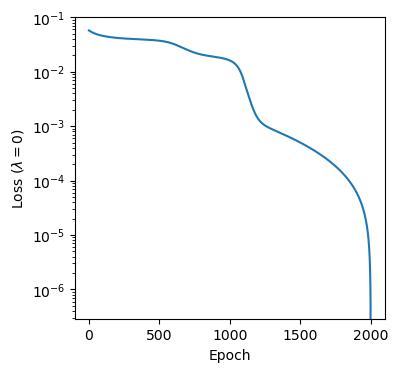

In [21]:
plt.figure(figsize=(4, 4), dpi=100)
plt.plot(np.array(lossRecord) - min(lossRecord))
plt.xlabel('Epoch')
plt.ylabel('Loss $(\lambda=0)$')
plt.yscale('log')
plt.show()

Now we can plot the (normalized) output likelihood function $\mathcal{L} (\theta | x)$ for various values of $x$.

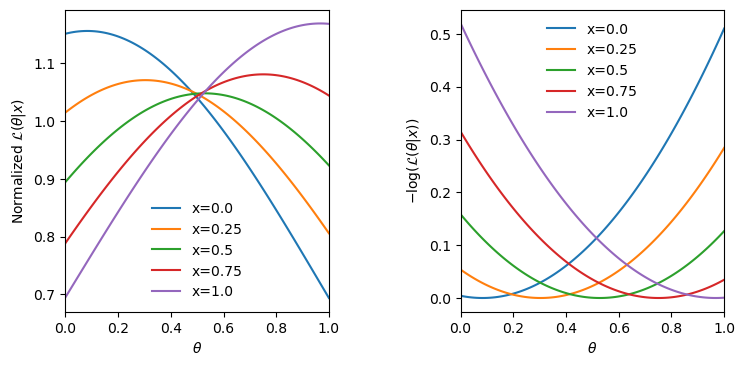

In [22]:
if network.gpu:
    network.cpu()

testObservables = torch.linspace(0, 1, 5).unsqueeze(1) # values of x at which to calculate L
testParameters = torch.linspace(0, 1, 100) # points of theta at which to evaluate L
testCoefficients = network(testObservables, cat=True) # calculate L for each of the five x values

fig, axs = plt.subplots(1, 2, figsize=(8.5, 4), dpi=100)
fig.subplots_adjust(wspace=0.5)
for testObservable, testCoefficient in zip(testObservables.detach().numpy(), testCoefficients.detach().numpy()):
    # left: Likelihood
    likelihoodFunction = stats.norm(loc=testCoefficient[0], scale=testCoefficient[1]) # scipy "norm" object
    likelihoodSamples = likelihoodFunction.pdf(testParameters) # sample the likelihood function at "testParameters"
    likelihoodSamples /= (likelihoodFunction.cdf(1) - likelihoodFunction.cdf(0) + 1e-9) # normalize
    axs[0].plot(testParameters, likelihoodSamples, label=f'x={testObservable.item()}')
    # right: NLL
    logLikelihoodSamples = -np.log(likelihoodSamples)
    logLikelihoodSamples -= min(logLikelihoodSamples)
    axs[1].plot(testParameters, logLikelihoodSamples, label=f'x={testObservable.item()}')

axs[0].set_xlabel(r'$\theta$')
axs[0].set_ylabel(r'Normalized $\mathcal{L}(\theta|x)$')
axs[0].set_xlim(0, 1)
axs[0].legend(frameon=False)
axs[1].set_xlabel(r'$\theta$')
axs[1].set_ylabel(r'$-\log(\mathcal{L}(\theta|x))$')
axs[1].set_xlim(0, 1)
axs[1].legend(frameon=False)
plt.show()

Now the network has been trainined. By eye, it seems to have learned what the desired function. That is, for values of x close to 0, the likelihood function $\mathcal{L}(\theta|x)$ is peaked near $\theta=0$. And, for values of x close to 0.75, the likelihood function $\mathcal{L}(\theta|x)$ is peaked near $\theta=0.75$.

Still, we would like to evaluate it's output more substantially.

In [23]:
def minima(array, *args):
    '''Finding minima of arrays

    In the first array, finds the minimum value and its index. For any other provided arrays, the value
    at that location is returned.'''
    min_i, min_v = min(enumerate(array), key=lambda x:x[1])
    extraMinima = []
    for extraArray in args:
        if not hasattr(extraArray, '__len__'): raise Exception('Non-array object passed to minima().')
        if not len(array)==len(extraArray): raise Exception('Unequal length object passed to minima().')
        extraMinima.append(extraArray[min_i])
    return tuple([min_i, min_v] + extraMinima)

def maximumLikelihoodFinder(likelihoodFunction):
    '''Takes in a likelihood function and calculates three objects:
    1) Location of the maximum.
    2) Bounds on that prediction (via a likelihood ratio test).
    3) Evaluation of that function.
    '''
    # This is where we shall sample the parameter
    parameterSamples = torch.linspace(0, 1, 200)
    # Calculate 2 * negative log (combined) likelihood
    negLogLikelihoodSamples = -2 * likelihoodFunction.log_prob(parameterSamples).sum(0)
    # Find the minimum of the summed likelihoods
    _, negLogLikelihoodMin, mle_theta = minima(negLogLikelihoodSamples, parameterSamples)
    # Subtract this baseline from likelihood values to get -2*delta(log likelihood)
    negLogLikelihoodSamples -= negLogLikelihoodMin.item()
    # Create a spline to determine perform a likelihood ratio test
    from scipy.interpolate import UnivariateSpline
    mle_bounds = UnivariateSpline(parameterSamples, negLogLikelihoodSamples - 1).roots()
    return mle_theta, mle_bounds, negLogLikelihoodSamples, parameterSamples

In [24]:
def validate(network, theta, n):
    '''Checks network outputs.

    For a given value theta, a dataset {x_i} is generated according to the model specified at
    the beginning. The dataset is passed through the network, and the sum of the NLL functions
    are calculated.'''
    # generate some data which corresponds to the parameter value theta
    data_validate = torch.normal(mean=theta*_MU_M+_MU_B, std=_SIGMA, size=(n, 1))
    # pass the data through the network and create a likelihood function
    mu_validate, sigma_validate, c_validate = network(data_validate)
    mu_validate, sigma_validate, c_validate = mu_validate.detach(), sigma_validate.detach(), c_validate.detach()
    likelihoodFunction = torch.distributions.Normal(mu_validate, sigma_validate)
    return maximumLikelihoodFinder(likelihoodFunction)

Here, we will set $\theta = 0.5$, generate a dataset $\{x_i\}$, pass each point through the network, generate a likelihood function $\mathcal{L}_i\left(\theta|x_i\right)$, take the product of all of the likelihoods, find the maximum, and perform a likelihood ratio test to calculate the bounds.

In [25]:
mle_theta, mle_bounds, likelihoodSamples, parameterSamples = validate(network, 0.5, 10)

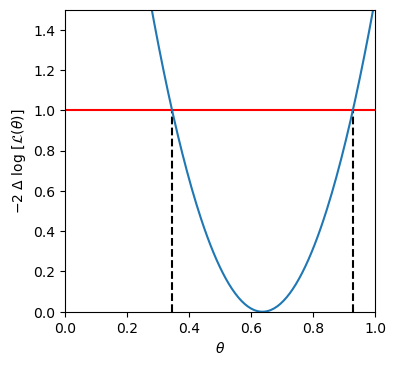

In [26]:
plt.figure(figsize=(4, 4), dpi=100)
plt.plot(parameterSamples, likelihoodSamples)
plt.hlines(1, 0, 1, color='r')
plt.vlines(mle_bounds, 0, 1, color='k', linestyle='dashed')
plt.xlim(0, 1)
plt.ylim(0, 1.5)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$-2~\Delta~\log~\left[ \mathcal{L}(\theta) \right]$')
plt.show()

We can see how the estimate gets more precise if we use a larger validation dataset. Instead of 10 points, let's generate 1000.

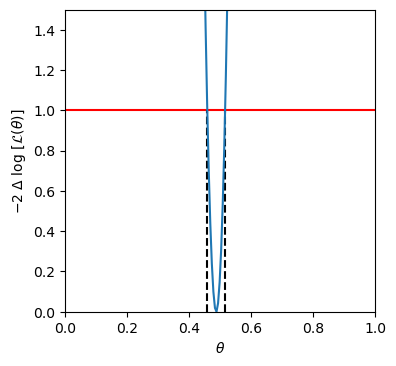

In [27]:
mle_theta, mle_bounds, likelihoodSamples, parameterSamples = validate(network, 0.5, 1000)

plt.figure(figsize=(4, 4), dpi=100)
plt.plot(parameterSamples, likelihoodSamples)
plt.hlines(1, 0, 1, color='r')
plt.vlines(mle_bounds, 0, 1, color='k', linestyle='dashed')
plt.xlim(0, 1)
plt.ylim(0, 1.5)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$-2~\Delta~\log~\left[ \mathcal{L}(\theta) \right]$')
plt.show()

The maximum likelihood value and uncertainy reported by the validation function should be consistent with the value which were input. Here, we will loop through 20 possible value of $\theta$, generate 1000 data points for each, and calculate the maximum likelihood and bounds for each. This ML should agree with the input theta.

In [28]:
test_thetas = np.linspace(0.05, 0.95, 20)
ml_thetas, ml_bounds = [], []
for test_theta in test_thetas:
    ml_theta, ml_bound, _, _ = validate(network, test_theta, 1000)
    ml_thetas.append(ml_theta)
    ml_bounds.append(ml_bound)
lower_bound, upper_bound = np.array(ml_bounds)[:, 0], np.array(ml_bounds)[:, 1]

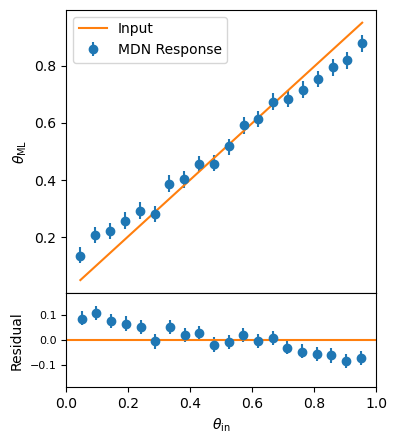

In [29]:
fig, axs = plt.subplots(2, 1, figsize=(4, 5), dpi=100, gridspec_kw={'height_ratios': [3, 1]});
fig.subplots_adjust(hspace=0)
errbars = np.array([ml_thetas-lower_bound, upper_bound-ml_thetas])

axs[0].errorbar(test_thetas, ml_thetas, yerr=errbars, fmt='o', label='MDN Response')
axs[0].plot(test_thetas, test_thetas, label='Input')
axs[0].set_ylabel(r'$\theta_\mathrm{ML}$')
axs[0].legend()

axs[1].errorbar(test_thetas, ml_thetas - test_thetas, yerr=errbars, fmt='o')
axs[1].plot([0, 0], label='Input')
axs[1].set_xlim(0, 1)
axs[1].set_ylim(-0.19, 0.19)
axs[1].tick_params(axis='y', labelsize=8)
axs[1].set_xlabel(r'$\theta_\mathrm{in}$')
axs[1].set_ylabel('Residual')

plt.show()

Clearly, the network is not behaving properly. The predicted $\theta_\mathrm{ML}$ is generally too close to the central value of 0.5. In the paper, we demonstrate how this issue is related to the distribution of the training data, and propose a corrective measure. As long as the value of
$$\int_{-\infty}^{\infty} \tilde p \left( \theta, x \right) dx$$
is the same for any value of $\theta$, the network will be unbiased. Therefore, we add a step in the training to penalize the network for allowing these integrals to not equal one another.

In [30]:
epochs = 2000
unbias = 1
lossRecord = []
printEpoch = max(int(epochs / 10), 1)

if network.gpu:
    network.cuda()

for epoch in range(epochs):
    coefficients = network(x_training.unsqueeze(1)) # make a prediction
    loss = network.lossFunction(t_training.unsqueeze(1), coefficients) # calculate the loss
    loss += unbias * network.likelihoodBias()
    network.optimizer.zero_grad() # prepare optimizer
    loss.backward() # compute each parameter's contribution to the loss
    network.optimizer.step() # optimizer modifies network parameters
    lossRecord.append(loss.data.item()) # record the loss
    if not epoch % printEpoch:
        print(f'Epoch: {epoch}, Loss: {loss.data.item():0f}')
print(f'Epoch: final, Loss: {loss.data.item():0f}')

Epoch: 0, Loss: -0.029239
Epoch: 200, Loss: -0.038600
Epoch: 400, Loss: -0.038747
Epoch: 600, Loss: -0.038836
Epoch: 800, Loss: -0.038896
Epoch: 1000, Loss: -0.038943
Epoch: 1200, Loss: -0.038981
Epoch: 1400, Loss: -0.039012
Epoch: 1600, Loss: -0.039037
Epoch: 1800, Loss: -0.039059
Epoch: final, Loss: -0.039077


In [31]:
if network.gpu:
    network.cpu()
test_thetas = np.linspace(0.05, 0.95, 20)
ml_thetas, ml_bounds = [], []
for test_theta in test_thetas:
    ml_theta, ml_bound, _, _ = validate(network, test_theta, 1000)
    ml_thetas.append(ml_theta)
    ml_bounds.append(ml_bound)
lower_bound, upper_bound = np.array(ml_bounds)[:, 0], np.array(ml_bounds)[:, 1]

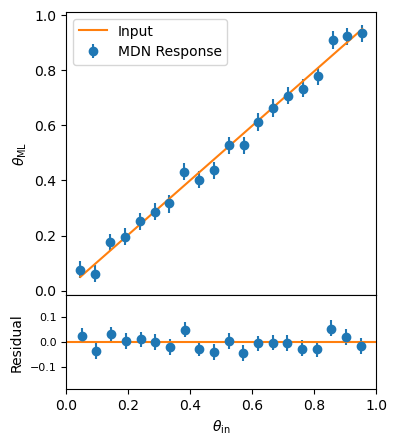

In [32]:
fig, axs = plt.subplots(2, 1, figsize=(4, 5), dpi=100, gridspec_kw={'height_ratios': [3, 1]});
fig.subplots_adjust(hspace=0)
errbars = np.array([ml_thetas-lower_bound, upper_bound-ml_thetas])

axs[0].errorbar(test_thetas, ml_thetas, yerr=errbars, fmt='o', label='MDN Response')
axs[0].plot(test_thetas, test_thetas, label='Input')
axs[0].set_ylabel(r'$\theta_\mathrm{ML}$')
axs[0].legend()

axs[1].errorbar(test_thetas, ml_thetas - test_thetas, yerr=errbars, fmt='o')
axs[1].plot([0, 0], label='Input')
axs[1].set_xlim(0, 1)
axs[1].set_ylim(-0.19, 0.19)
axs[1].tick_params(axis='y', labelsize=8)
axs[1].set_xlabel(r'$\theta_\mathrm{in}$')
axs[1].set_ylabel('Residual')

plt.show()

Fantastic! The network has now been trained, and the results appear to be unbiased. Some ideas to extend this introductory code:
*  Upgrade to a more sophisitcated dataset. Perhaps something bimodal. This will likely require using more than one basis Gaussian function.
*  Use a multi-dimensional input. Note that this can be very challenging from the point of calculating the joint probability. Generally, a 2D input is the maximum that one could reasonably do.
*  Try out different network hyperparameters: the number/size of hidden layers, the lambda parameter of the unbias procedure, the learning rate, the activation function, etc.